In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# importing required libraries
import seaborn as sns
sns.set()
sns.set(style="darkgrid")
import numpy as np
import pandas as pd

# importing matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize']=(10,10)

import pyspark
from pyspark.sql import functions as F
from pyspark.sql import types

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

warnings.filterwarnings('ignore')

In [4]:
# Connect to the Spark server
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [5]:
# Obtain the Data
fullpath = '/content/drive/MyDrive/28NOV/Listings.csv'

data = spark.read.csv(fullpath)

In [6]:
data

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string, _c25: string, _c26: string, _c27: string]

In [7]:
# read.csv is very similar to the Pandas version
data = spark.read.csv(fullpath,
                     sep=',',
                     inferSchema=True,
                     header=True,
                     multiLine=True)

data.printSchema()

root
 |-- listing_id: integer (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable = true)
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: double (nullable = true)
 |-- host_acceptance_rate: double (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_total_listings_count: integer (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- city: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- maximum_nights: integer (nullable = true)
 |-- review_scores_rating: integer (nullable = true)
 |-- review_scores_acc

### Data Preprocessing

In [8]:
# these columns are useless to us, drop them
drop_cols = ['listing_id','host_id','host_since','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost',
             'host_total_listings_count','host_has_profile_pic','host_identity_verified']
data = data.drop(*drop_cols)
data

DataFrame[host_location: string, neighbourhood: string, city: string, property_type: string, room_type: string, accommodates: int, bedrooms: int, price: int, minimum_nights: int, maximum_nights: int, review_scores_rating: int, review_scores_accuracy: int, review_scores_cleanliness: int, review_scores_checkin: int, review_scores_communication: int, review_scores_location: int, review_scores_value: int, instant_bookable: string]

In [9]:
# to chack the null values we create a DataFrame
df = data.toPandas()
df.shape

(279712, 18)

In [10]:
df.isnull().sum()

host_location                    832
neighbourhood                      0
city                               0
property_type                      0
room_type                          0
accommodates                       0
bedrooms                       29435
price                              0
minimum_nights                     0
maximum_nights                     0
review_scores_rating           91405
review_scores_accuracy         91713
review_scores_cleanliness      91665
review_scores_checkin          91771
review_scores_communication    91687
review_scores_location         91775
review_scores_value            91785
instant_bookable                   0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279712 entries, 0 to 279711
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   host_location                278880 non-null  object 
 1   neighbourhood                279712 non-null  object 
 2   city                         279712 non-null  object 
 3   property_type                279712 non-null  object 
 4   room_type                    279712 non-null  object 
 5   accommodates                 279712 non-null  int32  
 6   bedrooms                     250277 non-null  float64
 7   price                        279712 non-null  int32  
 8   minimum_nights               279712 non-null  int32  
 9   maximum_nights               279712 non-null  int32  
 10  review_scores_rating         188307 non-null  float64
 11  review_scores_accuracy       187999 non-null  float64
 12  review_scores_cleanliness    188047 non-null  float64
 13 

In [12]:
# dropping the null values
data = data.na.drop()

In [13]:
data.printSchema()

root
 |-- host_location: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- city: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- maximum_nights: integer (nullable = true)
 |-- review_scores_rating: integer (nullable = true)
 |-- review_scores_accuracy: integer (nullable = true)
 |-- review_scores_cleanliness: integer (nullable = true)
 |-- review_scores_checkin: integer (nullable = true)
 |-- review_scores_communication: integer (nullable = true)
 |-- review_scores_location: integer (nullable = true)
 |-- review_scores_value: integer (nullable = true)
 |-- instant_bookable: string (nullable = true)



In [14]:
# shape after dropping
print((data.count(), len(data.columns)))

(167720, 18)


**we convert pyspark to pandas dataframe for making EDA**

In [15]:
df = data.toPandas()
df.shape

(167720, 18)

**Before We Start the EDA we create new Dataframe with price less than 1000 to handle the outliers**

In [16]:
Newdf = df[(df["price"]<1000)]

In [17]:
Newdf.shape

(149055, 18)

In [18]:
Newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149055 entries, 0 to 167719
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   host_location                149055 non-null  object
 1   neighbourhood                149055 non-null  object
 2   city                         149055 non-null  object
 3   property_type                149055 non-null  object
 4   room_type                    149055 non-null  object
 5   accommodates                 149055 non-null  int32 
 6   bedrooms                     149055 non-null  int32 
 7   price                        149055 non-null  int32 
 8   minimum_nights               149055 non-null  int32 
 9   maximum_nights               149055 non-null  int32 
 10  review_scores_rating         149055 non-null  int32 
 11  review_scores_accuracy       149055 non-null  int32 
 12  review_scores_cleanliness    149055 non-null  int32 
 13  review_scores_

# **EDA**

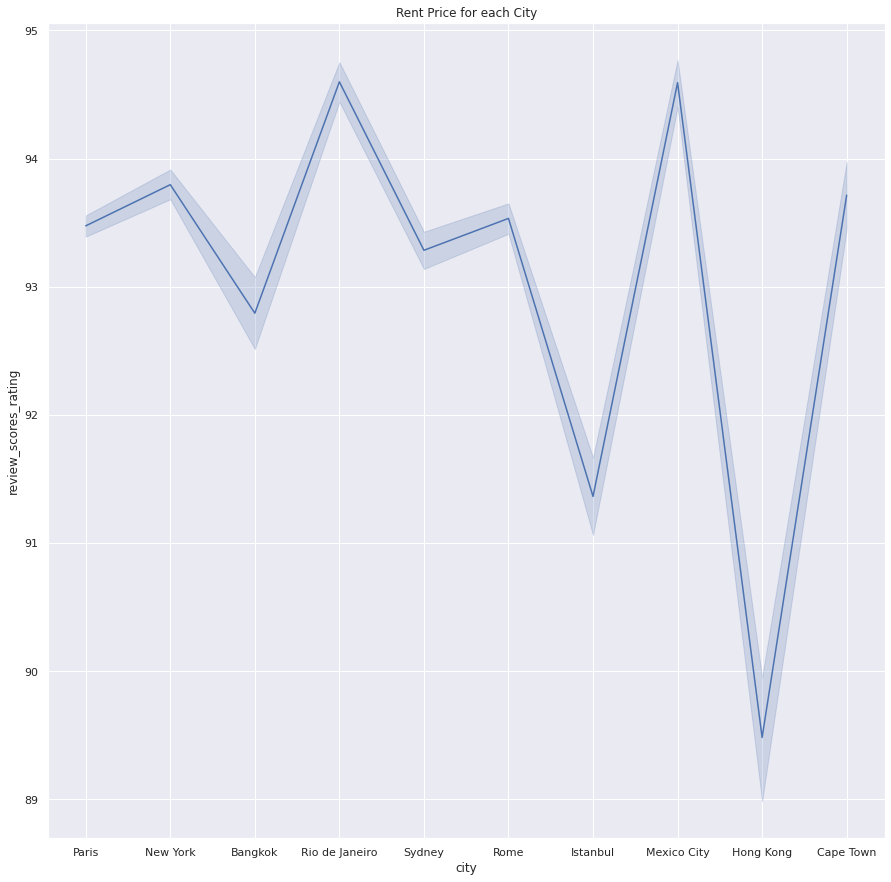

In [19]:
#lineplot
plt.figure(figsize=(15,15))
plt.title("Rent Price for each City")
sns.lineplot(x="city", y="review_scores_rating",data=Newdf)
plt.show()


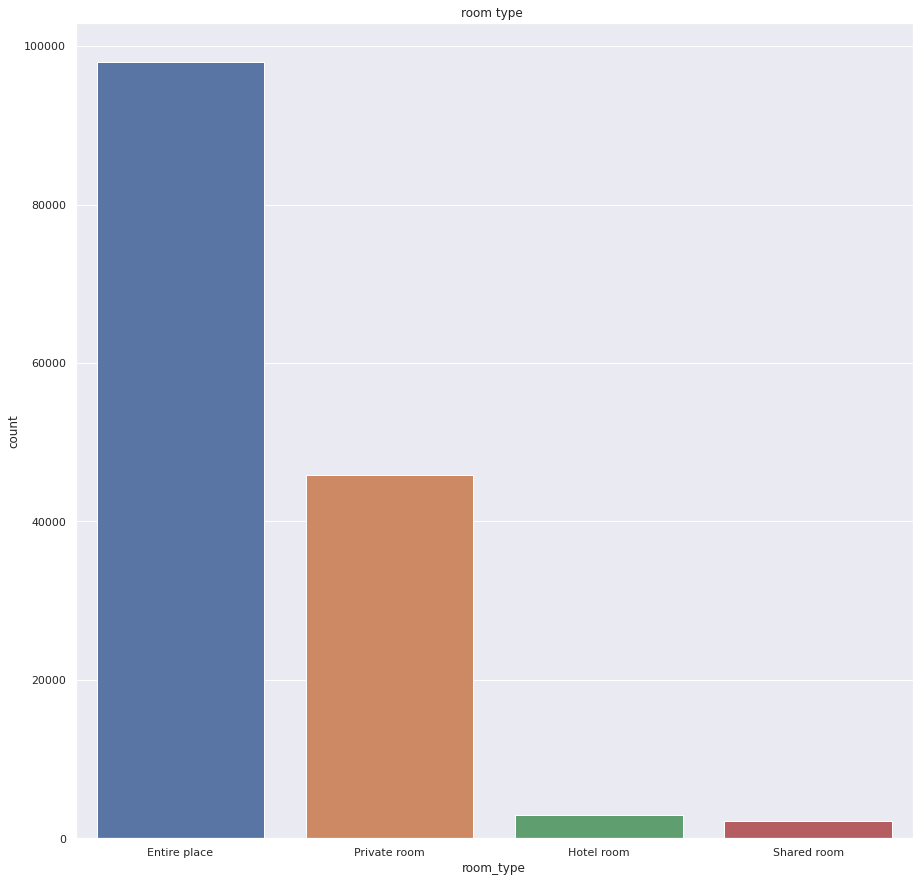

In [20]:
#countplot
plt.figure(figsize=(15,15))
plt.title("room type ")
sns.countplot(Newdf['room_type'])
plt.show()


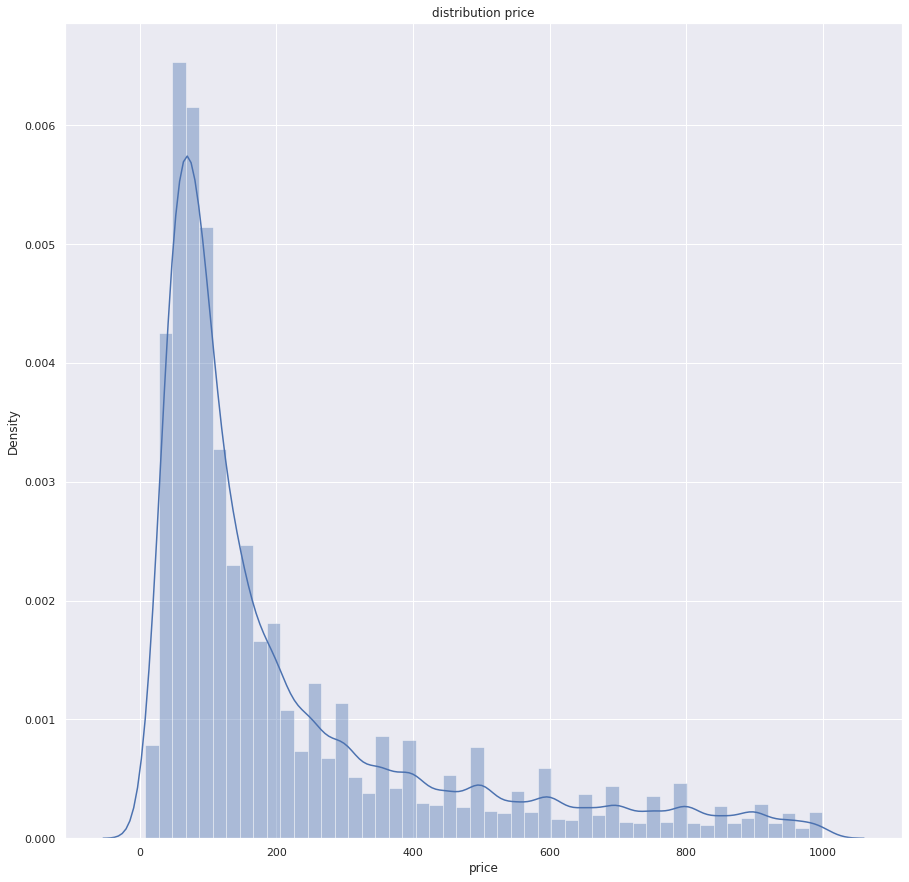

In [21]:
#distplot
plt.figure(figsize=(15,15))
plt.title("distribution price")
sns.distplot(Newdf['price'])
plt.show()


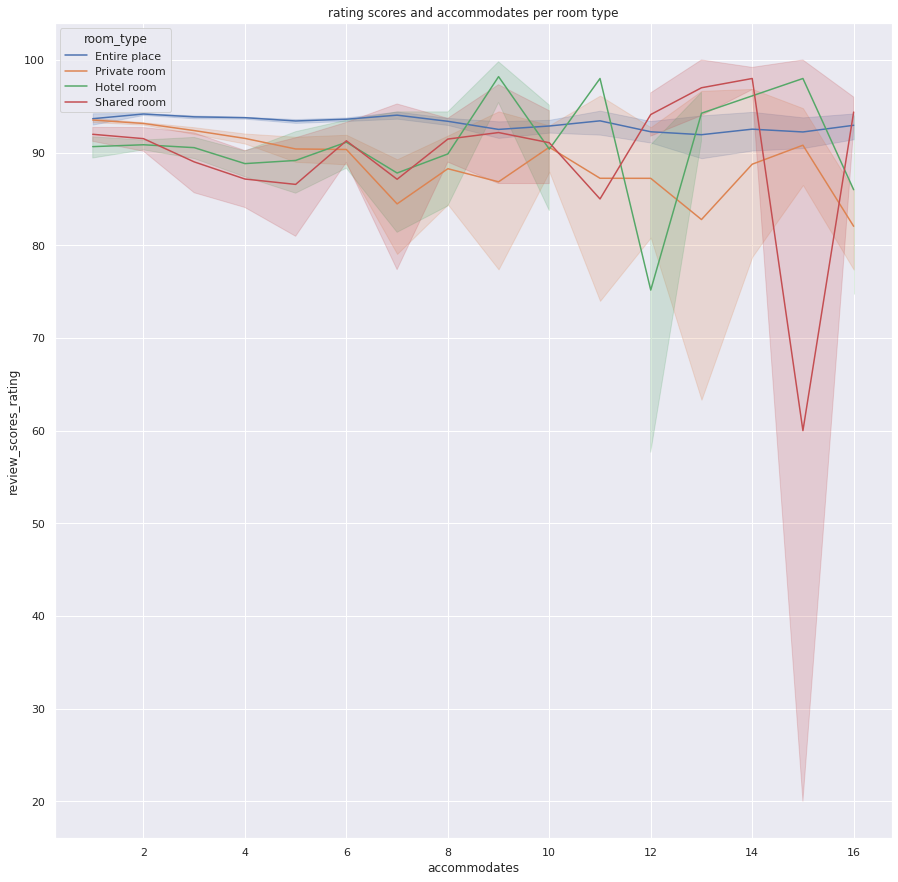

In [22]:
#distplot
plt.figure(figsize=(15,15))
plt.title("rating scores and accommodates per room type")
sns.lineplot(x="accommodates", y="review_scores_rating",hue='room_type',data=Newdf);

# **Models**

In [23]:
# we don't need the categorical columns so we dropped them
cat_cols = ['host_location','neighbourhood','city','property_type','room_type','instant_bookable']
data = data.drop(*cat_cols)
data

DataFrame[accommodates: int, bedrooms: int, price: int, minimum_nights: int, maximum_nights: int, review_scores_rating: int, review_scores_accuracy: int, review_scores_cleanliness: int, review_scores_checkin: int, review_scores_communication: int, review_scores_location: int, review_scores_value: int]

In [24]:
data.show()

+------------+--------+-----+--------------+--------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+
|accommodates|bedrooms|price|minimum_nights|maximum_nights|review_scores_rating|review_scores_accuracy|review_scores_cleanliness|review_scores_checkin|review_scores_communication|review_scores_location|review_scores_value|
+------------+--------+-----+--------------+--------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+
|           2|       1|   53|             2|          1125|                 100|                    10|                       10|                   10|                         10|                    10|                 10|
|           2|       1|  120|             2|          1125|                 100|                    10|     

In [25]:
cols = data.columns
assembler = VectorAssembler(inputCols=cols, outputCol='features')

data = assembler.transform(data)

In [26]:
# We have created a new dataframe only consisting of the features column and the label column
df_data = data.select(F.col('features'), F.col('review_scores_rating').alias('label'))

df_train, df_test = df_data.randomSplit([0.8, 0.2])

In [27]:
df_train.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



In [28]:
# Can specify what metrics we want to use. Default metric is Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator() 
grid = ParamGridBuilder().build()

In [29]:
#Random Forest Regressor
Regressor_rf = RandomForestRegressor(featuresCol='features', labelCol='label')
cv_rf = CrossValidator(estimator=Regressor_rf, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_rf = cv_rf.fit(df_train)

In [30]:
#Gradient Boosted Tree Regressor
Regressor_gbt = GBTRegressor(featuresCol="features", labelCol='label', maxIter=10)
cv_gbt = CrossValidator(estimator=Regressor_gbt, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_gbt = cv_gbt.fit(df_train)

In [31]:
#Decision Tree Regressor
Regressor_dt = DecisionTreeRegressor(featuresCol="features", labelCol='label')
cv_dt = CrossValidator(estimator=Regressor_dt, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_dt = cv_dt.fit(df_train)

In [32]:
#Linear Regression
Regression_lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
cv_lr = CrossValidator(estimator=Regression_lr, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_lr = cv_lr.fit(df_train)

In [33]:
metrics = []
models = [cv_model_rf, cv_model_gbt, cv_model_dt, cv_model_lr]

for model in models:
    metrics.append(model.avgMetrics)
print (metrics)

for idx, model in enumerate(models): 
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='r2').evaluate(model.bestModel.transform(df_test)))
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse').evaluate(model.bestModel.transform(df_test)))
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='mae').evaluate(model.bestModel.transform(df_test)))

df = pd.DataFrame(metrics, index = ['Random Forest Regressor', 'Gradient Boosted Tree Regressor', 'Decision Tree Regressor', 'Linear Regression'], columns=['Average Metrics (CV)', 'Best Model R2 on Test Set', 'Best Model RMSE on Test Set', 'Best Model MAE on Test Set'])

df

[[2.5083282666917106], [1.1555468097685648], [1.7076619304561482], [0.28531276129185235]]


,Average Metrics (CV),Best Model R2 on Test Set,Best Model RMSE on Test Set,Best Model MAE on Test Set
Random Forest Regressor,2.508328,0.941761,2.403196,1.427349
Gradient Boosted Tree Regressor,1.155547,0.986064,1.175560,0.269772
Decision Tree Regressor,1.707662,0.969960,1.725968,0.338097
Linear Regression,0.285313,0.999165,0.287778,0.180004
